In [106]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pylab as plt
import nltk
from nltk.corpus import stopwords
import math
import string
from wordcloud import WordCloud, STOPWORDS
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.) Choose a corpus of interest

### The dataset that I have chosen contains question and answer sentence pairs. It uses Bing query logs as the source of the questions and search engine answers from wikipedia as the answers portion. I Would like to look at both the questions and answers serparately

In [107]:
df = pd.read_csv("https://raw.githubusercontent.com/sphill12/Data_620/main/WikiQA-dev.txt", sep = None, header = None)

C:\Users\Steve\AppData\Local\Temp\ipykernel_20552\1061330050.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("https://raw.githubusercontent.com/sphill12/Data_620/main/WikiQA-dev.txt", sep = None, header = None)


## Exploratory Data Analysis:

In [108]:
df.head()

,0,1,2
0,How are epithelial tissues joined together ?,Cross section of sclerenchyma fibers in plant ...,0
1,How are epithelial tissues joined together ?,Microscopic view of a histologic specimen of h...,0
2,How are epithelial tissues joined together ?,"In Biology , Tissue is a cellular organization...",0
3,How are epithelial tissues joined together ?,A tissue is an ensemble of similar cells from ...,0
4,How are epithelial tissues joined together ?,Organs are then formed by the functional group...,0


### There are a total of 2733 Question and Answer pairs

In [109]:
df.shape

(2733, 3)

### There are no missing values

In [110]:
df.isna().sum()

0    0
1    0
2    0
dtype: int64

In [111]:
df.dtypes

0    object
1    object
2     int64
dtype: object

## Data Cleaning:

### Although we could analyze the text as is, I would like to distill it down to the most important information first. To do this, the numbers, stop words and punctuation will first be removed. I have defined several functions to do this:

In [112]:
## This will be used to count how many times each word is repeated
def count_words(text):
    return Counter(text.split())

## This will remove uninformative words such as "and" or "The"
def remove_stop_words(string):
    stop_words = set(stopwords.words("english"))
    words = string.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    new_string = " ".join(filtered_words)
    return new_string

In [113]:
## This will remove all puntuation from sentences
def remove_punctuations(text):
    # Tokenize the text into individual words
    words = text.split()

    # Remove punctuations from each word
    words_without_punctuations = [word for word in words if word not in string.punctuation]

    # Join the words back into a string
    text_without_punctuations = " ".join(words_without_punctuations)

    return text_without_punctuations

In [114]:
def remove_numeric(text):
    # Split text into individual words
    words = text.split()
    # Remove numbers from text
    words_without_numbers = [word for word in words if word not in ["0","1","2","3","4","5","6","7","8","9","+","-"]]

    # Join words back together
    text_without_numbers = " ".join(words_without_numbers)

    return text_without_numbers

In [115]:
## Rename columns
df.columns = ["question", "answer", "integer"]

### We can use lambda functions with our defined functions to iterate over the dataframe and clean it

In [116]:
## First make all letters lowercase
df[["question","answer"]] = df[["question","answer"]].apply(lambda x: x.str.lower())

punctuation_trans = {string.punctuation:""}
df["question"] = df["question"].apply(lambda x: x.translate(punctuation_trans))
## Remove punctuation

translator = str.maketrans('', '', string.punctuation)
df["question"] = df["question"].apply(lambda x: x.translate(translator))
df["answer"] = df["answer"].apply(lambda x: x.translate(translator))
df["question"] = df["question"].apply(lambda x: remove_punctuations(x))
df["answer"] = df["answer"].apply(lambda x: remove_punctuations(x))
## Remove stop words
df["question"] = df["question"].apply(lambda x: remove_stop_words(x))
df["answer"] = df["answer"].apply(lambda x: remove_stop_words(x))

## Remove numeric
df["question"] = df["question"].apply(lambda x: remove_numeric(x))
df["answer"] = df["answer"].apply(lambda x: remove_numeric(x))

## Analysis:

In [117]:
## Count the unique words in the questions
word_count_questions = df["question"].apply(count_words)
total_words_questions = Counter()
for count in word_count_questions:
    total_words_questions.update(count)

word_counts_question_dict = dict(total_words_questions)


In [118]:
## Count the unique words in the answers
word_count_answers = df["answer"].apply(count_words)
total_words_answers = Counter()
for count in word_count_answers:
    total_words_answers.update(count)

word_count_answer_dict = dict(total_words_answers)

In [119]:
## Convert dictionaries to dataframes for easier analysis
question_counts_df = pd.DataFrame(list(word_counts_question_dict.items()))
question_counts_df.columns = ["word","count"]

answer_counts_df = pd.DataFrame(list(word_count_answer_dict.items()))
answer_counts_df.columns = ["word","count"]

### Just based on the most popular words, we can see that questions are oriented around people, their deaths, the earth, and things that happened in 2010

In [120]:
question_counts_df = question_counts_df.sort_values(by = "count", ascending= False)
top200_questions = question_counts_df.head(200)
top200_questions_dict = top200_questions.set_index("word")["count"].to_dict()
question_counts_df.head(20)

,word,count
44,many,319
50,people,78
204,2010,72
223,die,68
285,come,66
202,go,66
120,take,63
22,much,61
314,name,60
130,earth,59


### The answers to the questions are oriented around the united states, the world, wars, or locations

In [121]:
answer_counts_df =answer_counts_df.sort_values(by = "count", ascending= False)
top200_answers =answer_counts_df.head(200)
top200_answers_dict= top200_answers.set_index("word")["count"].to_dict()
answer_counts_df.head(20)

,word,count
183,states,194
173,first,183
339,also,166
182,united,166
230,one,156
79,american,133
201,world,128
156,may,100
629,state,94
38,known,91


## Question 2:

### How many total unique words are in the corpus?

In [122]:
print("There are " + str(question_counts_df.shape[0]) + " Unique words in the Questions Corpus")

There are 851 Unique words in the Questions Corpus


In [123]:
print("There are " + str(answer_counts_df.shape[0]) + " Unique words in the Answers Corpus")

There are 10423 Unique words in the Answers Corpus


### There are about 3 times the total words in the questions data than the answers data:

In [124]:
print("There are:", str(question_counts_df["count"].sum()),"total words in the question data")
print("There are:", str(answer_counts_df["count"].sum()),"total words in the answer data")

There are: 10133 total words in the question data
There are: 34941 total words in the answer data


In [125]:
count = 0
question_list =[]
for i in range(len(question_counts_df["word"])):
    if count >= (question_counts_df["count"].sum()/2):
        break
    count += question_counts_df["count"][i]
    question_list.append(question_counts_df["word"][i])


## Question 3:

### Taking the most common words, how many unique words represent half of the total words in the corpus?

In [126]:
print(str(len(question_list)), "unique words represent", str(round((question_counts_df["count"].sum()/2),0)), "total words in the Questions Corpus")

332 unique words represent 5066.0 total words in the Questions Corpus


In [127]:
count = 0
answer_list =[]
for i in range(len(answer_counts_df["word"])):
    if count >= (answer_counts_df["count"].sum()/2):
        break
    count += answer_counts_df["count"][i]
    answer_list.append(answer_counts_df["word"][i])


In [128]:
print(str(len(answer_list)), "unique words represent", str(round((answer_counts_df["count"].sum()/2),0)), "total words in the Answers Corpus")

2373 unique words represent 17470.0 total words in the Answers Corpus


### The proportion of unique words to total words for the answers corpus is much larger than for the questions corpus

In [129]:
print("the ratio of unique words to total words in the question corpus is:", str(round(len(question_list)/(question_counts_df["count"].sum()/2),5)))
print("the ratio of unique words to total words in the answer corpus is:", str(round(len(answer_list)/(answer_counts_df["count"].sum()/2),5)))

the ratio of unique words to total words in the question corpus is: 0.06553
the ratio of unique words to total words in the answer corpus is: 0.13583


## Question 4:

### Identify the 200 highest frequency words in this corpus


### List of 200 highest frequency words in the Questions Corpus:

In [130]:
print(top200_questions_dict.keys())

dict_keys(['many', 'people', '2010', 'die', 'come', 'go', 'take', 'much', 'name', 'earth', 'year', 'first', 'part', 'get', 'world', 'known', 'song', 'become', 'us', 'water', 'used', 'war', 'colors', 'country', 'lincoln', 'times', '50', 'current', 'born', 'kind', 'kids', 'money', 'mean', 'book', 'flatlands', 'city', 'pre', 'george', 'original', 'calc', 'bar', 'related', 'national', 'nature', 'died', 'arb', 'washington', 'medications', 'cup', 'rate', 'found', 'new', 'school', 'states', 'state', 'macarthur', 'exam', 'highest', 'movie', 'usa', 'day', 'abraham', 'dominican', 'cheese', 'important', 'resource', 'mercury', 'natural', 'republic', 'molecules', 'cottage', 'color', 'lipoic', 'organic', 'acid', 'happened', 'old', 'temperature', 'away', 'difference', 'far', 'judaism', 'laws', 'long', 'human', 'olympics', 'time', 'arctic', 'mexico', 'oceans', 'justinian', 'reserve', 'percentage', 'body', 'john', 'took', 'ireland', 'federal', 'emperor', 'league', '141334', 'oklahoma', 'elvis', 'bombin

### List of 200 highest frequency words in the Answers Corpus:

In [131]:
print(top200_answers_dict.keys())

dict_keys(['states', 'first', 'also', 'united', 'one', 'american', 'world', 'may', 'state', 'known', 'us', 'city', 'two', 'war', 'many', 'system', 'series', 'new', 'used', 'federal', 'film', 'well', 'time', 'years', 'three', 'century', 'since', '2011', 'including', 'major', 'four', 'season', 'million', 'president', 'north', 'national', 'number', 'area', 'people', 'government', 'released', 'second', 'water', 'country', '2010', 'album', 'later', 'became', 'earth', 'party', 'part', 'different', '2008', 'public', 'made', 'called', 'name', 'often', 'television', 'league', 'south', 'year', 'song', 'population', 'early', 'life', 'washington', 'board', 'games', 'large', 'law', 'ocean', 'largest', 'form', 'color', 'body', 'born', 'times', 'rock', '2009', '–', 'include', 'empire', 'general', 'several', 'began', 'following', 'music', 'although', 'power', 'western', 'however', 'use', 'much', '2007', 'york', 'france', 'day', 'list', 'best', 'popular', 'planet', 'based', 'congress', 'america', 'home

### This is not very informative, so a word cloud can give us a better idea of what words are important to the corpus.

## Question 5:

### Create a graph that shows the relative frequency of these 200 words:

## Questions Corpus:

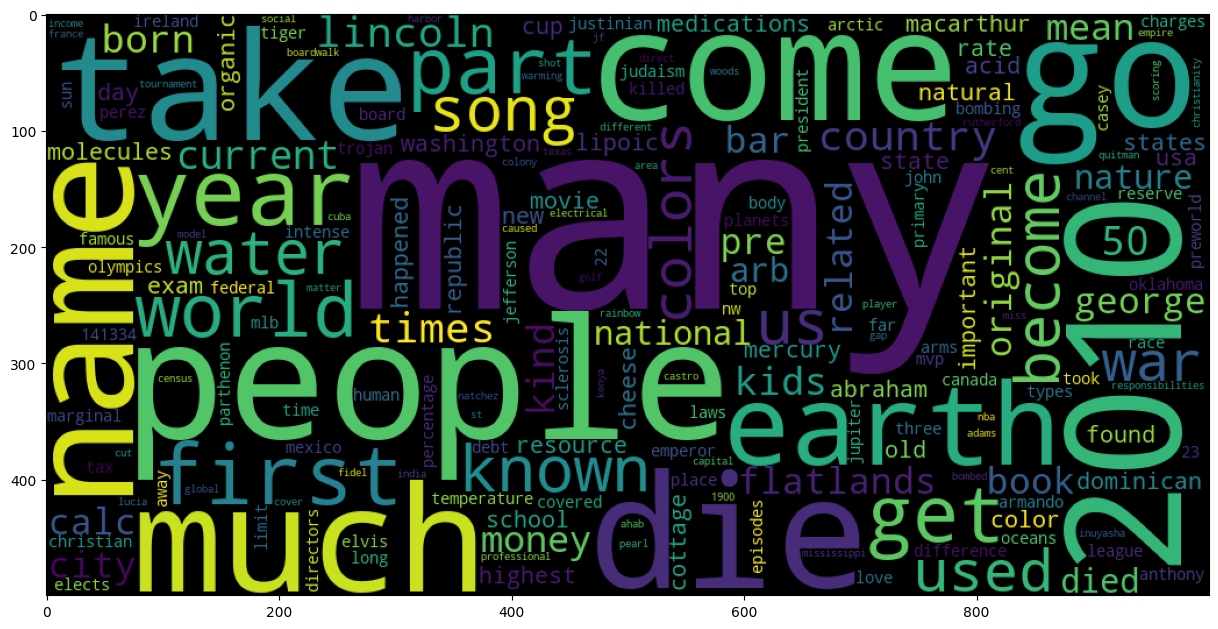

In [132]:
wc = WordCloud(width = 1000, height = 500).generate_from_frequencies(top200_questions_dict)
plt.figure(figsize =(15,8))
plt.imshow(wc)

## Answers Corpus:

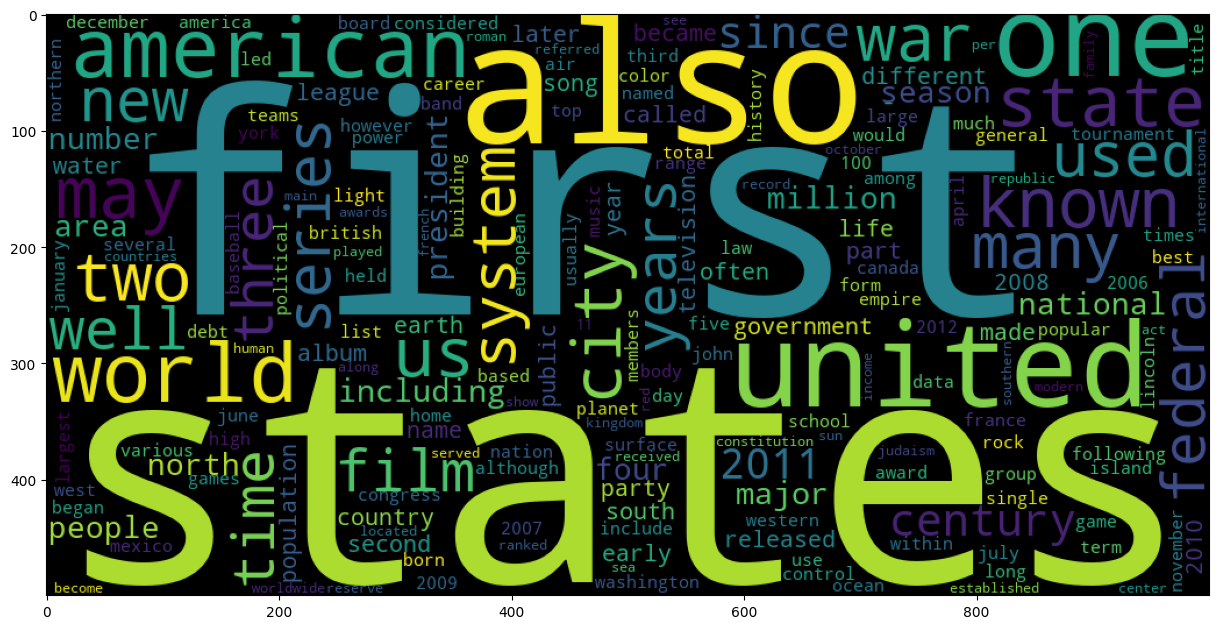

In [133]:
wc = WordCloud(width = 1000, height = 500).generate_from_frequencies(top200_answers_dict)
plt.figure(figsize =(15,8))
plt.imshow(wc)

## Question 6:
### Does the observed Relative Frequency of these words follow Zipf's Law?

### Zipf's law states that the frequencies of words are inversely proportional to their ranks. The most common word should appear twice as often as the second most frequent word, three times as often as the subsequent word, etc. The word in position n should appear 1/n times as often as the most frequent one. We can check this with both the answers and questions corpus:

In [134]:
print("The first ranked word is " + str(round((question_counts_df["count"].iloc[0] / question_counts_df["count"].iloc[1]),1)), "times more frequent than the second ranked word in the question corpus")

The first ranked word is 4.1 times more frequent than the second ranked word in the question corpus


In [135]:
print("The first ranked word is " + str(round((answer_counts_df["count"].iloc[0] / answer_counts_df["count"].iloc[1]),0)), "times more frequent than the second ranked word in the answer corpus")

The first ranked word is 1.0 times more frequent than the second ranked word in the answer corpus


### Based on this, neither of the corpuses closely follow Zipf's law. It is possible that if stop words were not removed from the corpuses then they would more closely follow Zipf's law

## Question 7:

### In what ways does the freqency of the words in this corpus differ from "all words in all corpora"

### According to https://www.techtarget.com/whatis/definition/Zipfs-Law , when all texts are plotted with frequency agains rank, the result is a logarithmic curve. The word "the" appears about one-tenth of the time in text, while the word "of" appears one twentieth of the time. We can see how closely our corpus freqency models the logarithmic curve by plotting it.

In [136]:

answer_counts_df = answer_counts_df.reset_index()
answer_counts_df = answer_counts_df[["word","count"]]

question_counts_df = question_counts_df.reset_index()
question_counts_df = question_counts_df[["word","count"]]

In [137]:
question_counts_df

,word,count
0,many,319
1,people,78
2,2010,72
3,die,68
4,come,66
...,...,...
846,hung,1
847,jury,1
848,chow,1
849,dish,1


In [138]:
x_val = [item for item in range(10423)]
x_val1 = [item for item in range(851)]
log = [(1/math.log10(x + 2)) for x in x_val]

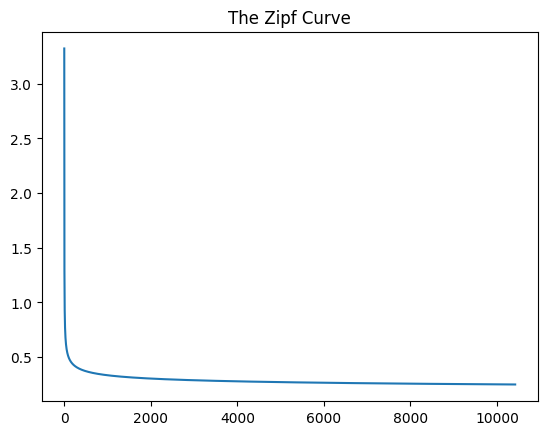

In [139]:
fig, ax = plt.subplots()
ax.plot(x_val,log)
ax.set(title = "The Zipf Curve")
plt.show()

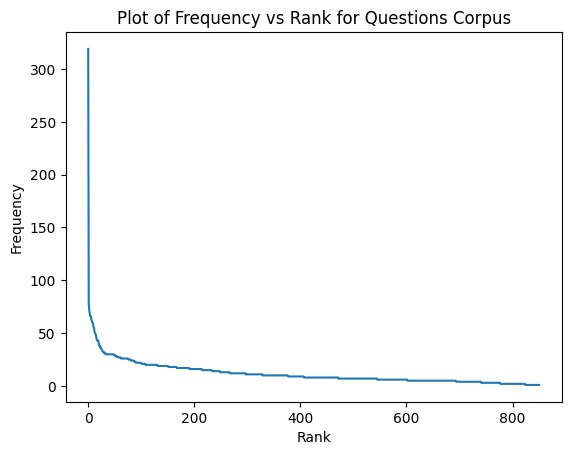

In [140]:
fig, ax = plt.subplots()
ax.plot(x_val1, question_counts_df["count"])
ax.set(title = "Plot of Frequency vs Rank for Questions Corpus", xlabel = "Rank", ylabel = "Frequency")
plt.show()

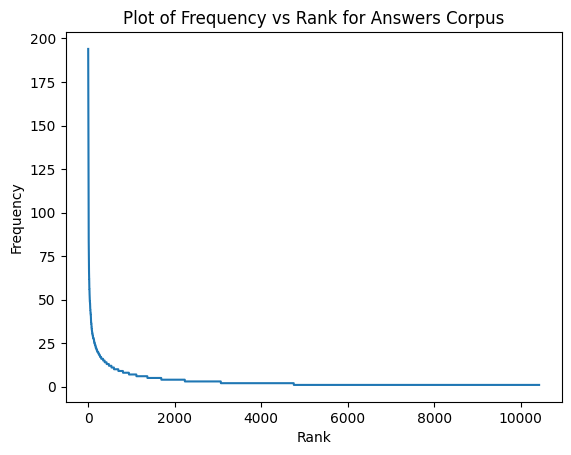

In [141]:
fig, ax = plt.subplots()
ax.plot(x_val, answer_counts_df["count"])
ax.set(title = "Plot of Frequency vs Rank for Answers Corpus", xlabel = "Rank", ylabel= "Frequency")
plt.show()

### Although the first few values in our two corpus do not follow Zipf's law that closely, the overall plot of frequency versus rank looks similar to the logarithmic curve that we would expect

In [142]:
log_x1 = [math.log10(x + 1) for x in x_val1]
log_counts_question = [math.log10(y) for y in question_counts_df["count"]]


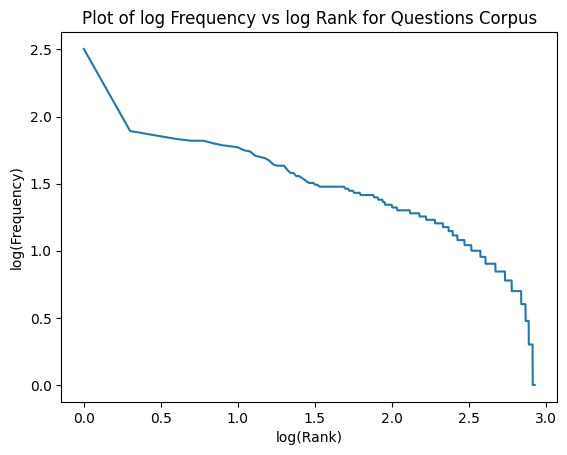

In [143]:
fig, ax = plt.subplots()
ax.plot(log_x1, log_counts_question)
ax.set(title = "Plot of log Frequency vs log Rank for Questions Corpus", xlabel = "log(Rank)", ylabel = "log(Frequency)")
plt.show()

In [144]:
log_x2 = [math.log10(x + 1) for x in x_val]
log_counts_answer = [math.log10(y) for y in answer_counts_df["count"]]

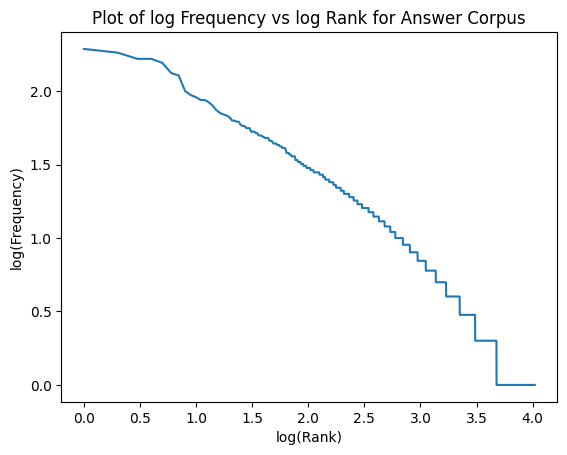

In [146]:
fig, ax = plt.subplots()
ax.plot(log_x2, log_counts_answer)
ax.set(title = "Plot of log Frequency vs log Rank for Answer Corpus", xlabel = "log(Rank)", ylabel = "log(Frequency)")
plt.show()